In [1]:
#! pip install seaborn

In [2]:
#! pip install  xlrd
import warnings
import datetime
import warnings
import json
import pandas as pd
import time
import csv
warnings.filterwarnings("ignore")
import xlrd
import glob
import os

#def read_excel_2_df(filepath):
#    shop_address = "".join(filepath.split("|")[1].strip()).split(".")[0]
#    shop_name = "".join(filepath.split("|")[0].strip()).split("/")[-1:][0]
#    
#    df = pd.read_excel(filepath, skiprows=1)
#    df_selected_cols = df[['Unnamed: 2', 'Unnamed: 3','Taste and Quantity of Coffee', 'Price', 'Speed of the service', 'Atmosphere / Friendliness', 'Walking Distance', 'Unnamed: 9','Unnamed: 10',  'Unnamed: 12', 'Unnamed: 13']]
#    df_selected_cols.columns = ['email', 'coffee_bought','Taste_and_Quantity_of_Coffee', 'Price', 'Speed_of_the_service', 'Atmosphere_Friendliness', 'Walking_Distance', 'Comments','date_purchase',  'country', 'state']
#    df_selected_cols["shop_address"] =shop_address
#    df_selected_cols["shop_name"] =  shop_name
#    return df_selected_cols


In [3]:
pd_coffee_survay = pd.read_excel("data/all_together.xlsx", ignore_index=True)
pd_coffee_survay["shop_name"],pd_coffee_survay["shop_address"]  = pd_coffee_survay["Address"].str.split("|",1).str

rating_mapping = {
      "Very Bad": -2,
      "Bad":-1,
      "Neutral": 0,
      "Good": 1, 
      "Very Good": 2
      }

pd_coffee_survay.columns = ['Image', 'Address', 'News_email', 'Coffee_ordered',
       'Taste_Quantity', 'Price', 'Service_Speed',
       'Atmosphere_Friendliness', 'Walking_Distance', 'Comments',
       'Date', 'Time_Taken', 'Country_Code', 'Region_Code', 'First_Name',
       'Last_Name', 'Email', 'Custom_Field', 'Participant_code',
       'Completed', 'External_ID',"shop_name", 'shop_address']
pd_coffee_survay_1 = pd_coffee_survay.replace({"Taste_Quantity":rating_mapping})\
    .replace({"Price":rating_mapping})\
    .replace({"Service_Speed":rating_mapping})\
    .replace({"Atmosphere_Friendliness":rating_mapping})\
    .replace({"Walking_Distance":rating_mapping}).dropna(how='all')

In [4]:
pd_coffee_survay_1.columns

Index(['Image', 'Address', 'News_email', 'Coffee_ordered', 'Taste_Quantity',
       'Price', 'Service_Speed', 'Atmosphere_Friendliness', 'Walking_Distance',
       'Comments', 'Date', 'Time_Taken', 'Country_Code', 'Region_Code',
       'First_Name', 'Last_Name', 'Email', 'Custom_Field', 'Participant_code',
       'Completed', 'External_ID', 'shop_name', 'shop_address'],
      dtype='object')

In [7]:
df_rating = pd_coffee_survay_1[['shop_name', 'Taste_Quantity','Price','Service_Speed', 'Atmosphere_Friendliness', 'Walking_Distance']].groupby(['shop_name']).agg(['mean'])
df_rating.columns = ['Taste_Quantity','Price','Service_Speed', 'Atmosphere_Friendliness', 'Walking_Distance']
df_rating.sort_values("Price")
df_plot = df_rating.reset_index()
df_plot["Score"] = df_plot.sum(axis=1)
df_plot

,shop_name,Taste_Quantity,Price,Service_Speed,Atmosphere_Friendliness,Walking_Distance,Score
0,CJs Central,1.000000,1.600000,1.200000,0.600000,0.000000,4.400000
1,Frothy,0.833333,1.000000,0.500000,1.333333,0.666667,4.333333
2,​The Reformatory Caffeine Lab,0.800000,0.800000,1.000000,1.400000,0.600000,4.600000
3,Cafe And Cucina,1.333333,0.666667,1.000000,0.833333,1.500000,5.333333
4,Camys Chargrill Chicken,0.571429,1.000000,1.000000,0.428571,0.571429,3.571429
5,Citta Cafe,1.333333,0.833333,1.166667,1.333333,1.500000,6.166667
6,Di Bella Coffee Roasting Warehouse​,1.000000,0.833333,1.000000,1.166667,1.166667,5.166667
7,Kippax Coffee,0.333333,1.333333,0.166667,0.666667,1.500000,4.000000
8,Lion corner Cafe,0.800000,1.000000,0.800000,0.600000,1.200000,4.400000
9,News corp Coffee,0.500000,1.000000,0.833333,0.666667,1.500000,4.500000


## Analysis

In [8]:
# Total entires
len(pd_coffee_survay_1)

101

In [9]:
# Coffee shops by score
df_plot.sort_values("Score",ascending=False)

,shop_name,Taste_Quantity,Price,Service_Speed,Atmosphere_Friendliness,Walking_Distance,Score
5,Citta Cafe,1.333333,0.833333,1.166667,1.333333,1.500000,6.166667
10,Orto Trading Co.,1.000000,1.000000,1.500000,1.166667,0.833333,5.500000
12,Point Blank,1.250000,0.750000,1.250000,1.000000,1.250000,5.500000
3,Cafe And Cucina,1.333333,0.666667,1.000000,0.833333,1.500000,5.333333
6,Di Bella Coffee Roasting Warehouse​,1.000000,0.833333,1.000000,1.166667,1.166667,5.166667
11,Ouroboros Wholefoods Cafe,0.600000,1.000000,1.200000,1.000000,1.000000,4.800000
13,Presse Cafe,0.600000,1.400000,1.200000,0.600000,0.800000,4.600000
2,​The Reformatory Caffeine Lab,0.800000,0.800000,1.000000,1.400000,0.600000,4.600000
9,News corp Coffee,0.500000,1.000000,0.833333,0.666667,1.500000,4.500000
8,Lion corner Cafe,0.800000,1.000000,0.800000,0.600000,1.200000,4.400000


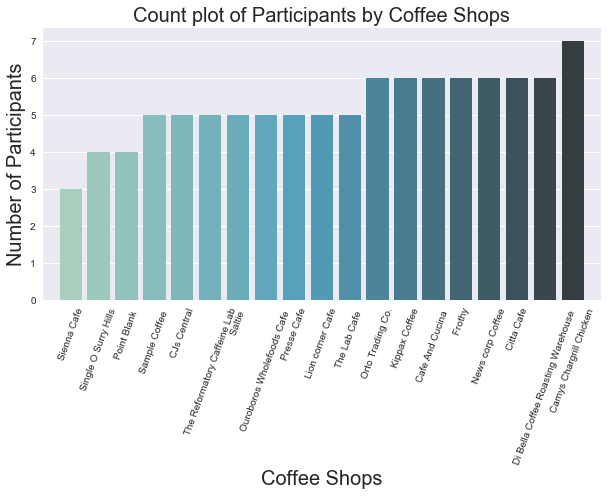

In [11]:
# Visualize
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style='darkgrid')

## Participants by Coffee Shops

plt.figure(figsize=(10,5))
sns.countplot(x='shop_name', \
              data=pd_coffee_survay_1, \
              order=pd_coffee_survay_1['shop_name'].value_counts().index, 
              palette=sns.color_palette("GnBu_d", 20))

plt.title("Count plot of Participants by Coffee Shops", fontsize=20)
plt.xlabel('Coffee Shops', fontsize=20)
plt.ylabel('Number of Participants', fontsize=20)
# Set the length of the bar chart
plt.xlim(len(pd_coffee_survay_1[['shop_name']].groupby(['shop_name']).count()),-1)
plt.xticks(rotation=70, fontsize=10)
plt.show()

## parallel_coordinates

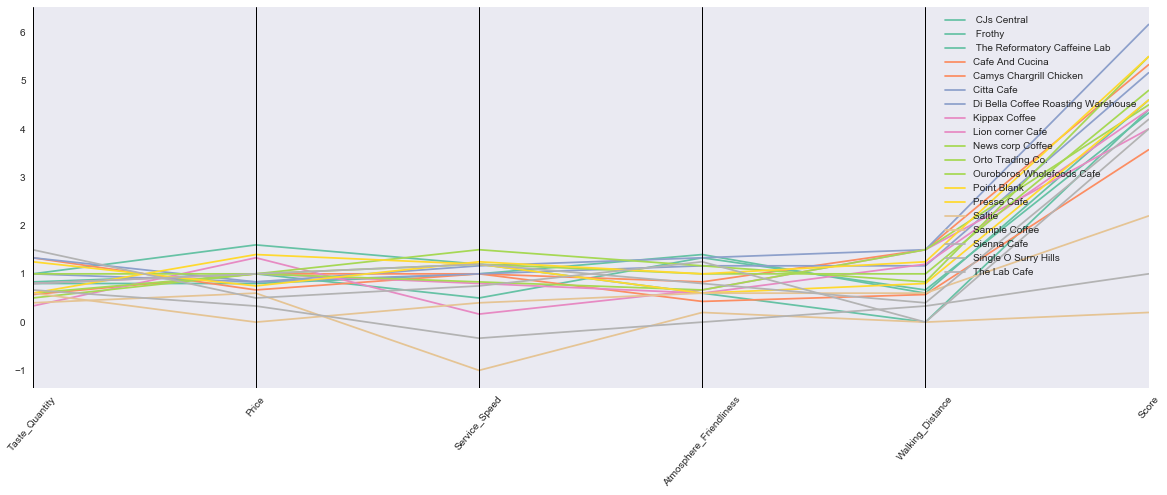

In [12]:
from pandas.tools.plotting import parallel_coordinates
plt.figure(figsize=(20,7))
parallel_coordinates(df_plot,"shop_name",colormap=plt.get_cmap("Set2"))
plt.xticks(rotation=50, fontsize=10)
plt.show()

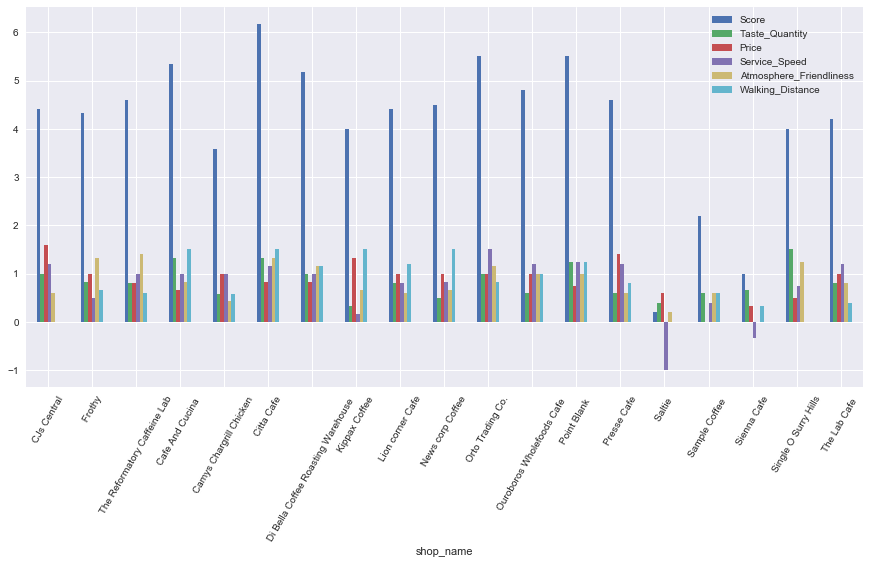

In [13]:
df_plot.plot.bar(x=df_plot['shop_name'],y=['Score','Taste_Quantity','Price','Service_Speed', 'Atmosphere_Friendliness', 'Walking_Distance'],figsize=(15,7), rot=60)

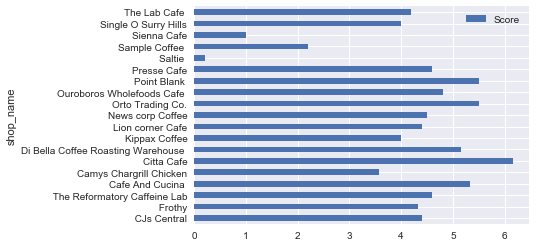

In [14]:
df_plot.plot.barh(x=df_plot['shop_name'],y=['Score'])

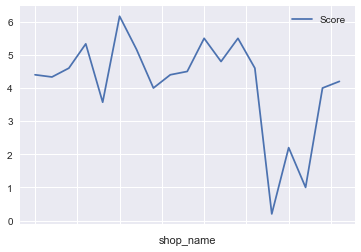

In [15]:
df_plot.plot.line(x=df_plot['shop_name'],y=['Score'])
plt.xticks(rotation=60, fontsize=10)
plt.show()

<module 'matplotlib.pyplot' from '/Users/sampathkumarv/news/venkat/airflow/venv/lib/python3.6/site-packages/matplotlib/pyplot.py'>

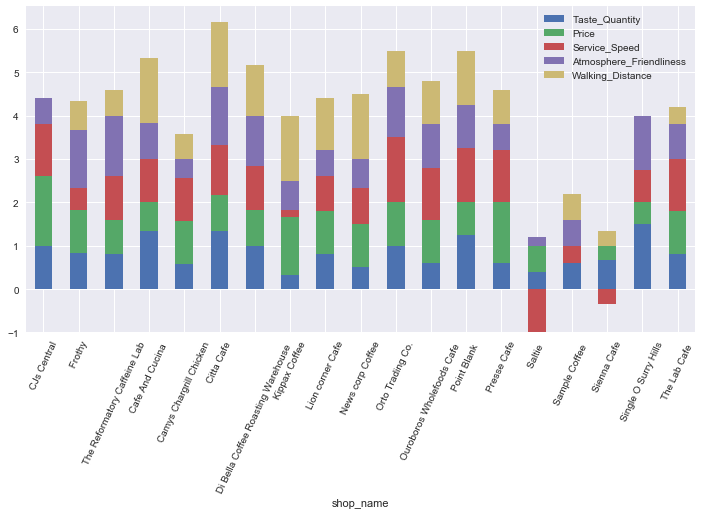

In [33]:
df_plot.iloc[:,:6].plot(x=df_plot['shop_name'],kind='bar', stacked=True, figsize=(12,6), rot=65)
plt

In [31]:
df_plot.sort_values( "Score", ascending=False)[:10]

,shop_name,Taste_Quantity,Price,Service_Speed,Atmosphere_Friendliness,Walking_Distance,Score
5,Citta Cafe,1.333333,0.833333,1.166667,1.333333,1.500000,6.166667
10,Orto Trading Co.,1.000000,1.000000,1.500000,1.166667,0.833333,5.500000
12,Point Blank,1.250000,0.750000,1.250000,1.000000,1.250000,5.500000
3,Cafe And Cucina,1.333333,0.666667,1.000000,0.833333,1.500000,5.333333
6,Di Bella Coffee Roasting Warehouse​,1.000000,0.833333,1.000000,1.166667,1.166667,5.166667
11,Ouroboros Wholefoods Cafe,0.600000,1.000000,1.200000,1.000000,1.000000,4.800000
13,Presse Cafe,0.600000,1.400000,1.200000,0.600000,0.800000,4.600000
2,​The Reformatory Caffeine Lab,0.800000,0.800000,1.000000,1.400000,0.600000,4.600000
9,News corp Coffee,0.500000,1.000000,0.833333,0.666667,1.500000,4.500000
8,Lion corner Cafe,0.800000,1.000000,0.800000,0.600000,1.200000,4.400000


In [32]:
# copy data from download to data folder 
#find ~/Downloads/ -mtime -1 -name '*Export Clone of News Corp Coffee Club - Best Coffee Shop*.xlsx' -type f -print -exec cp  {} . \;

In [20]:
#rating_mapping = {
#      "Very Bad": -2,
#      "Bad":-1,
#      "Neutral": 0,
#      "Good": 1, 
#      "Very Good": 2
#      }
#
#final_pd_df = pd.DataFrame()
#for files in dir_listing:
#    if not "need_to_fix" in files:
#        print(files)
#        final_pd_df = pd.concat([final_pd_df, read_excel_2_df(files)], ignore_index=True)
#        final_pd_df = final_pd_df.replace({"Taste_and_Quantity_of_Coffee":rating_mapping})\
#            .replace({"Price":rating_mapping})\
#            .replace({"Speed_of_the_service":rating_mapping})\
#            .replace({"Atmosphere_Friendliness":rating_mapping})\
#            .replace({"Walking_Distance":rating_mapping})
##final_pd_df

In [21]:
#df_rating = final_pd_df[['shop_name', 'Taste_and_Quantity_of_Coffee','Price','Speed_of_the_service', 'Atmosphere_Friendliness', 'Walking_Distance']].groupby(['shop_name']).agg(['mean'])
#df_rating.columns = ['mean_Taste_and_Quantity_of_Coffee','mean_Price','mean_Speed_of_the_service', 'mean_Atmosphere_Friendliness', 'mean_Walking_Distance']
#df_rating.sort_values("mean_Price")
#df_plot = df_rating.reset_index()
#df_plot

In [22]:
#df_plot.mean()

In [23]:
#pd_final_mean = df_rating.mean()
#df_final_mean = pd.DataFrame({'shop_name':pd_final_mean.index, 'overall_rating':pd_final_mean.values})
#df_final_mean

# Visualize

In [24]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style='darkgrid')

## Participants by Coffee Shops

In [25]:
plt.figure(figsize=(10,5))
sns.countplot(x='shop_address', \
              data=final_pd_df, \
              order=final_pd_df['shop_address'].value_counts().index, 
              palette=sns.color_palette("GnBu_d", 20))

plt.title("Count plot of Participants by Coffee Shops", fontsize=20)
plt.xlabel('Coffee Shops', fontsize=20)
plt.ylabel('Number of Participants', fontsize=20)
# Set the length of the bar chart
plt.xlim(len(final_pd_df[['shop_name']].groupby(['shop_name']).count()),-1)
plt.xticks(rotation=70, fontsize=10)
plt.show()

NameError: name 'final_pd_df' is not defined

<Figure size 720x360 with 0 Axes>

In [26]:
parallel_coordinates?

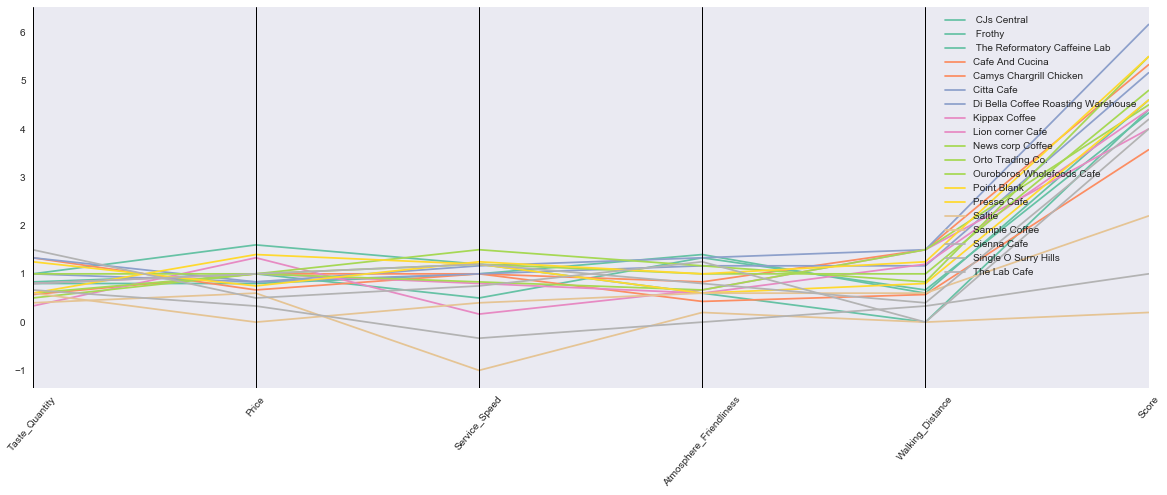

In [27]:
from pandas.tools.plotting import parallel_coordinates
plt.figure(figsize=(20,7))
parallel_coordinates(df_plot, "shop_name",colormap=plt.get_cmap("Set2"))
plt.xticks(rotation=50, fontsize=10)
plt.show()

In [28]:
df_final_mean

NameError: name 'df_final_mean' is not defined

In [29]:
#plt.figure(figsize=(10,7))

df_final_mean.plot.line(x=df_final_mean['shop_name'],y=['overall_rating'])
plt.xticks(rotation=60, fontsize=10)
plt.show()

NameError: name 'df_final_mean' is not defined

In [30]:
df_plot.plot.bar?
df_plot.plot.bar(x=df_plot['shop_name'],y=['mean_Taste_and_Quantity_of_Coffee'])

KeyError: "['mean_Taste_and_Quantity_of_Coffee'] not in index"